In [287]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os, csv, time
import numpy as np
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize, MinMaxScaler

from sklearn.metrics.pairwise import linear_kernel
from multichannel.multichannel_model import MultiChannelModel, multichannel_KFoldCV
from multichannel.theano_kernels import theano_rbf as rbf_kernel, theano_chi2 as chi2_kernel

from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from multichannel.weighted_ridge import WeightedRidge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#paths to mappings/features
dataset_root = '/home/luke/projects/THE_dataset' #directory where features/labels kept
mapping_path = os.path.join(dataset_root, 'ratings_by_filename_it35.csv')
train_path = os.path.join(dataset_root, 'train_set.pkl')
test_path = os.path.join(dataset_root, 'test_set.pkl')
c3d_path = os.path.join(dataset_root, 'C3D_features_wLoad.npz')

In [4]:
#load labels
def load_mapping(mapping_path):
    with open(mapping_path, 'rb') as f:
        import csv
        cr = csv.reader(f)
        mapping_list = []
        for row in cr:
            row[1] = float(row[1])
            mapping_list.append(row)
    return mapping_list            

In [5]:
#function for assigning labels to feature_dict
def assign_label(feature_dict, mapping):
    for ii,name in enumerate(feature_dict['Video_Name']):
        mapping_row = filter(lambda x: x[0] == name[0], mapping)[0]
        label = float(mapping_row[1])
        feature_dict['Label'][ii] = label        
    return feature_dict

In [6]:
#function - adding in c3d features
def incorporate_c3d(feature_dict, c3d_feats, c3d_names):
    num_instances = len(feature_dict['HOG']) #number of instances
    num_c3d_feats = c3d_feats.shape[1]
    c3d = np.empty((num_instances, num_c3d_feats))
    for ii, video_name in enumerate(feature_dict['Video_Name']):
        ind = np.where(c3d_names == video_name[0])[0][0]
        c3d[ii,:] = c3d_feats[ind,:]
    feature_dict['c3d'] = c3d
    return feature_dict

In [7]:
#function for turning feature_dict into multi-channel tuple
def prep_multichannel_data(feature_dict, return_labels=False, feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy']):
    multichannel_list = []
    for feature in feature_list:
        data = np.array(feature_dict[feature])
        #normalise
        if feature=='c3d':
            data_norm = normalize(data, axis=1, norm='l2')
        else:
            data_norm = normalize(data, axis=1, norm='l1')
        multichannel_list.append(data_norm)    
    if not return_labels:
        return tuple(multichannel_list)
    else:
        labels = feature_dict['Label']
        return tuple(multichannel_list), np.array(labels)

In [8]:
#save the results
def save_results(video_name_list, y_test, y_pred, filename='SVR_traj_c3d_combined_results.csv'):
    with open(filename, 'wb') as f:
        import csv
        cw = csv.writer(f)
        cw.writerow(['Video_Name', 'y_test', 'y_pred'])
        for ii, name in enumerate(video_name_list):
            row = [name, y_test[ii], y_pred[ii]]
            cw.writerow(row) 

In [9]:
#visualise
def plot_regression(y_test, y_pred, score=None, scatter_color='blue', title=' '):
    
    #plot on axis
    fig, ax = plt.subplots(figsize=(15,12))
    ax.scatter(y_test, y_pred, alpha=.2, s=120, color=scatter_color)
    
    #perfect model line
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            linestyle='-', color='k', linewidth=2, label='Perfect prediction')
    
    #line of best fit to the learned model
    par = np.polyfit(y_test, y_pred, 1, full=True)
    m = par[0][0]; c=par[0][1]
    model_line_x = [min(y_test), max(y_test)]
    model_line_y = [m*x + c for x in model_line_x]
    ax.plot(model_line_x, model_line_y, 
            linestyle='--', color=scatter_color, linewidth=2, label='Model prediction')
    
    #put in the R score
    if score:
        ax.text(model_line_x[1]+.2, model_line_y[1], r'$R={:.2f}$'.format(score), fontsize=18, color=scatter_color)
    
    #axis formatting
    ax.set_xlim([10,45])
    ax.set_ylim([10,45])
    ax.set_xlabel(r'Load (observed)', fontsize=16, labelpad=20)
    ax.set_ylabel(r'Load (model)', fontsize=16, labelpad=20)
    ax.set_title(title, fontsize=16)
    
    #misc
    ax.legend()
    ax.grid(True)
    
    return fig, ax

### Data preparation

In [10]:
#load the datasets
train_set = joblib.load(train_path)
test_set = joblib.load(test_path)
c3d_all = np.load(c3d_path)

In [11]:
mapping = load_mapping(mapping_path)

In [12]:
train_data = assign_label(train_set.feature_dict, mapping)
test_data = assign_label(test_set.feature_dict, mapping)
train_data_wc3d = incorporate_c3d(train_data, c3d_all['all_fvs'], c3d_all['all_filenames'])
test_data_wc3d = incorporate_c3d(test_data, c3d_all['all_fvs'], c3d_all['all_filenames'])

In [13]:
feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy', 'c3d']
X_train, y_train = prep_multichannel_data(train_data_wc3d, return_labels=True, feature_list=feature_list)
X_test, y_test = prep_multichannel_data(test_data_wc3d, return_labels=True, feature_list=feature_list)

In [319]:
# train_path = os.path.join(dataset_root, 'train_set_wc3d.pkl')
# test_path = os.path.join(dataset_root, 'test_set_wc3d.pkl')
# tr = joblib.dump((X_train, y_train), train_path)
# te = joblib.dump((X_test, y_test), test_path)

In [320]:
X_train, y_train = joblib.load(train_path)
X_test, y_test = joblib.load(test_path)

In [322]:
X_train[0].shape

(1206, 4000)

### Multichannel models with linear kernel

In [323]:
def ridge_grid_search(C_range):
    kpt = {'kernel_func': linear_kernel, 'param_dict': {}}
    results_array = np.empty((len(C_range), 1)) #results array 
    for C_ind, C in enumerate(C_range):
        #initialise the regressor
        model = Ridge(alpha=C)
        mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
        scores = multichannel_KFoldCV(mcm, X_train, y_train, n_folds=5, verbose=False)
        results_array[C_ind] = np.mean(scores)
    return results_array

def svr_grid_search(C_range):
    kpt = {'kernel_func': linear_kernel, 'param_dict': {}}
    results_array = np.empty((len(C_range), 1)) #results array 
    for C_ind, C in enumerate(C_range):
        #initialise the regressor
        model = SVR(kernel='precomputed', C=C)
        mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
        scores = multichannel_KFoldCV(mcm, X_train, y_train, n_folds=5, verbose=False)
        results_array[C_ind] = np.mean(scores)
    return results_array

#ridge
C_range = [.001, .01, .1, 1, 10, 100]
ridge_res = ridge_grid_search(C_range)
print ridge_res, '\n'

#svr
#C_range = [.25, .5, .75, 1, 1.25]
svr_res = svr_grid_search(C_range)
print svr_res

[[ 0.49226013]
 [ 0.49370548]
 [ 0.50458509]
 [ 0.53720695]
 [ 0.56148624]
 [ 0.54232704]] 

[[ 0.04272074]
 [ 0.23526045]
 [ 0.47266877]
 [ 0.54847179]
 [ 0.49957587]
 [ 0.49957587]]


training time: 0.47895693779
R^2 score of 0.580376164499 
Correlation of 0.761824234649


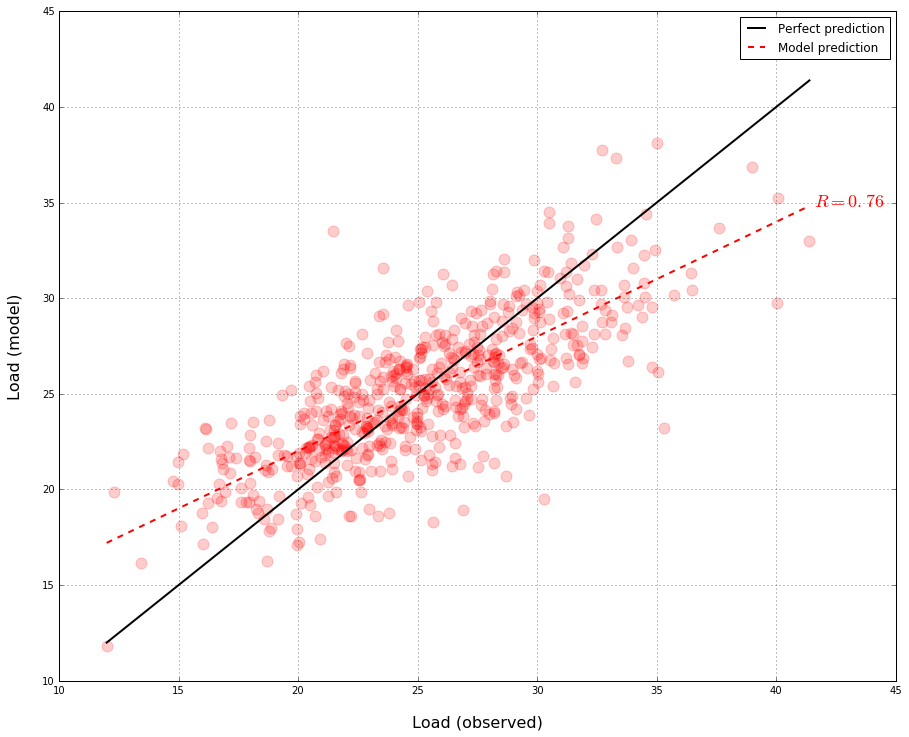

In [54]:
#plot best linear RIDGE
#set kernel params
kpt = {'kernel_func': linear_kernel, 'param_dict': {}}

#training
t0= time.time()
model = Ridge(alpha=10)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
mcm.fit(X_train, y_train)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

#predict
y_pred = mcm.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

#plot
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), 
                          scatter_color='red', 
                          )


training time: 0.827121019363
R^2 score of 0.570299813385 
Correlation of 0.755181973689


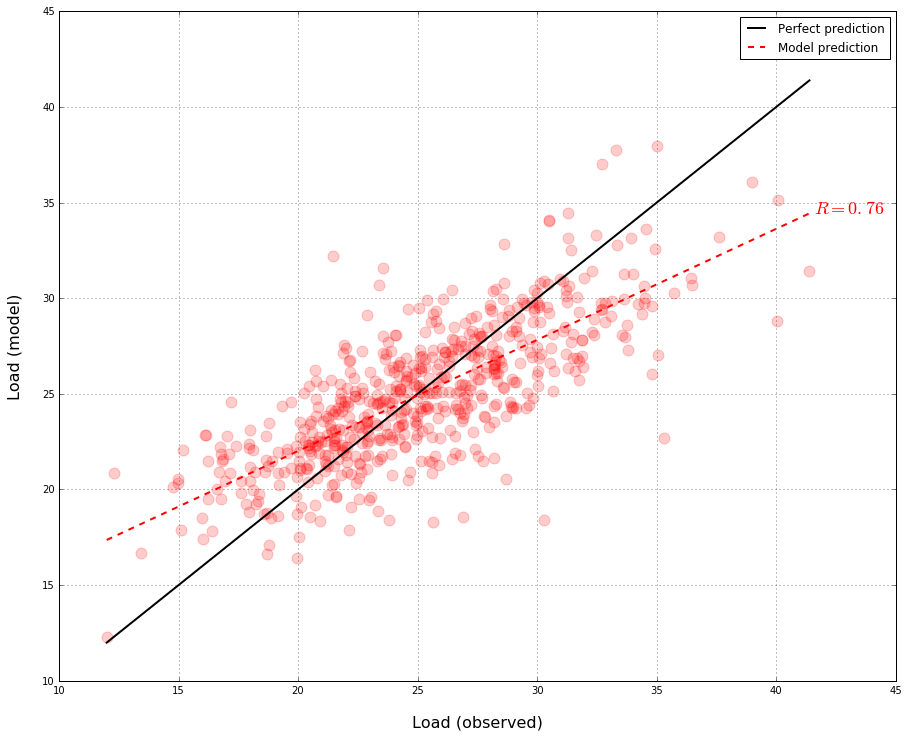

In [55]:
#plot best linear SVR
#set kernel params
kpt = {'kernel_func': linear_kernel, 'param_dict': {}}

#training
t0= time.time()
model = SVR(kernel='precomputed', C=1)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
mcm.fit(X_train, y_train)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

#predict
y_pred = mcm.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

#plot
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), 
                          scatter_color='red', 
                          )


### Multichannel models with non-linear kernels

In [213]:
#helper function for creating the kpt
def create_kpt(num_channels, gammas):
    kernel_param_list = []
    for channel in xrange(num_channels):
        if channel < 4:
            kdict = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gammas[channel]}}
        elif channel == 5:
            kdict = {'kernel_func': rbf_kernel, 'param_dict': {'gamma': gammas[channel]}}
        kernel_param_list.append(kdict)
    kernel_param_tuple = tuple(kernel_param_list)
    return kernel_param_tuple

#### SVR

In [217]:
#do COARSE grid search within each channel!
num_channels = 6
gamma_range = [.001, .01, .1, 1, 10]
coarse_res_array = np.zeros((num_channels, len(gamma_range)))
for channel in xrange(num_channels):
    current_X_train = (X_train[channel],)
    for gamma_ind, gamma in enumerate(gamma_range):
        model = SVR(kernel='precomputed', C=1)
        kpt = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}}
        mcm = MultiChannelModel(num_channels=1, model=model, kernel_param_tuple=kpt)
        score_list = multichannel_KFoldCV(mcm, current_X_train, y_train)
        coarse_res_array[channel, gamma_ind] = np.mean(score_list)
print 'Coarse search (channels X gamma): \n', coarse_res_array

KeyboardInterrupt: 

In [ ]:
# do FINE grid search within each channel!
# Based on coarse fit:
# search powers of 2 from .1 for traj features and from .01 for c3d features
num_channels=6
gamma_range = [.1, .2, .4, .8, 1.6, 3.2, 6.4]
#gamma_range_c3d = [.01, .02, .04, .08, .16, .32, .64] # effective: division by 10 in the loop for channel5
fine_res_array = np.zeros((num_channels, len(gamma_range)))
for channel in xrange(num_channels):
    print channel
    current_X_train = (X_train[channel],)
    for gamma_ind, gamma in enumerate(gamma_range):
        model = SVR(kernel='precomputed', C=1)
        kpt = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}}
        if channel == 5:
            gamma=gamma/float(10) # for c3d features
            kpt = {'kernel_func': rbf_kernel, 'param_dict': {'gamma': gamma}}
        mcm = MultiChannelModel(num_channels=1, model=model, kernel_param_tuple=kpt)
        score_list = multichannel_KFoldCV(mcm, current_X_train, y_train)
        fine_res_array[channel, gamma_ind] = np.mean(score_list)
    
print 'Fine search: \n', fine_res_array

In [223]:
#opt gammas for SVR
Traj_gamma = 3.2 # score .360
HOG_gamma = 1.6 # score 0.467
HOF_gamma = 1.6 # score 0.431
MBHx_gamma = 3.2 # score 0.436
MBHy_gamma = 3.2 # score 0.443
c3d_gamma = .04 # _WITH CHI2_ score .534 NB gamma = .1 in the coarse search gave .54
c3d_gamma_rbf = 2 # score .533
gammas = (Traj_gamma, HOG_gamma, HOF_gamma, MBHx_gamma, MBHy_gamma, c3d_gamma_rbf)

In [224]:
##now do search across C holding these gamma weights true
gammas = (Traj_gamma, HOG_gamma, HOF_gamma, MBHx_gamma, MBHy_gamma, c3d_gamma_rbf)
kpt = create_kpt(6, gammas)
C_range = [.01, .1, 1, 5, 15, 30]
res_list=[]
for C in C_range:
    model = SVR(kernel='precomputed', C=C)
    mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
    score_list = multichannel_KFoldCV(mcm, X_train, y_train)
    res_list.append(np.mean(score_list))
    print C, score_list

0.01 [0.26016766752438591, 0.25187389105229518, 0.27640810882450439]
0.1 [0.53863849813092868, 0.50742460120753297, 0.52635205511664274]
1 [0.55970266196138074, 0.52946297078066173, 0.54912464595064359]
5 [0.55970266196138074, 0.52946297078066173, 0.54912464595064359]
15 [0.55970266196138074, 0.52946297078066173, 0.54912464595064359]
30 [0.55970266196138074, 0.52946297078066173, 0.54912464595064359]


#### Ridge regression

In [ ]:
#do COARSE grid search within each channel!
num_channels = 6
gamma_range = [.001, .01, .1, 1, 10]
coarse_res_array = np.zeros((num_channels, len(gamma_range)))
for channel in xrange(num_channels):
    current_X_train = (X_train[channel],)
    for gamma_ind, gamma in enumerate(gamma_range):
        model = SVR(kernel='precomputed', C=1)
        kpt = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}}
        mcm = MultiChannelModel(num_channels=1, model=model, kernel_param_tuple=kpt)
        score_list = multichannel_KFoldCV(mcm, current_X_train, y_train)
        coarse_res_array[channel, gamma_ind] = np.mean(score_list)
print 'Coarse search (channels X gamma): \n', coarse_res_array

In [ ]:
# do FINE grid search within each channel!
# Based on coarse fit:
# search powers of 2 from .1 for traj features and from .01 for c3d features

num_channels=6
gamma_range = [.1, .2, .4, .8, 1.6, 3.2, 6.4]
#gamma_range_c3d = [.01, .02, .04, .08, .16, .32, .64] # effective: division by 10 in the loop for channel5
fine_res_array = np.zeros((num_channels, len(gamma_range)))
for channel in xrange(num_channels):
    print channel
    current_X_train = (X_train[channel],)
    for gamma_ind, gamma in enumerate(gamma_range):
        model = SVR(kernel='precomputed', C=1)
        kpt = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}}
        if channel == 5:
            gamma=gamma/float(10) # for c3d features
            kpt = {'kernel_func': rbf_kernel, 'param_dict': {'gamma': gamma}}
        mcm = MultiChannelModel(num_channels=1, model=model, kernel_param_tuple=kpt)
        score_list = multichannel_KFoldCV(mcm, current_X_train, y_train)
        fine_res_array[channel, gamma_ind] = np.mean(score_list)
    
print 'Fine search: \n', fine_res_array

### Example weighting during fitting

In [ ]:
#determine the weights of the set
from scipy.stats import norm #assume gaussian
def example_weights(y):
    loc = np.mean(y)
    scale = np.std(y)
    fx = [norm.pdf(example, loc, scale) for example in y]
    return 1/np.array(fx)

In [258]:
##now do search across C holding these gamma weights true
gammas = (Traj_gamma, HOG_gamma, HOF_gamma, MBHx_gamma, MBHy_gamma, c3d_gamma_rbf)
kpt = create_kpt(6, gammas)
alpha_range = [.01, .1, 1, 5, 15, 30]
w = example_weights(y_train)
res_list=[]
for alpha in alpha_range:
    #model = Ridge(alpha=alpha)
    model = SVR(kernel='precomputed', C=alpha)
    mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
    #score_list = multichannel_KFoldCV(mcm, X_train, y_train, fit_params={'sample_weight': w})
    mcm.fit(X_train, y_train, fit_params={'sample_weight': w})
    score = mcm.score(X_test, y_test)
    res_list.append(score)
    print alpha, score

0.01 0.602809805609
0.1 0.60260288559
1 0.60260288559
5 0.60260288559
15 0.60260288559
30 0.60260288559


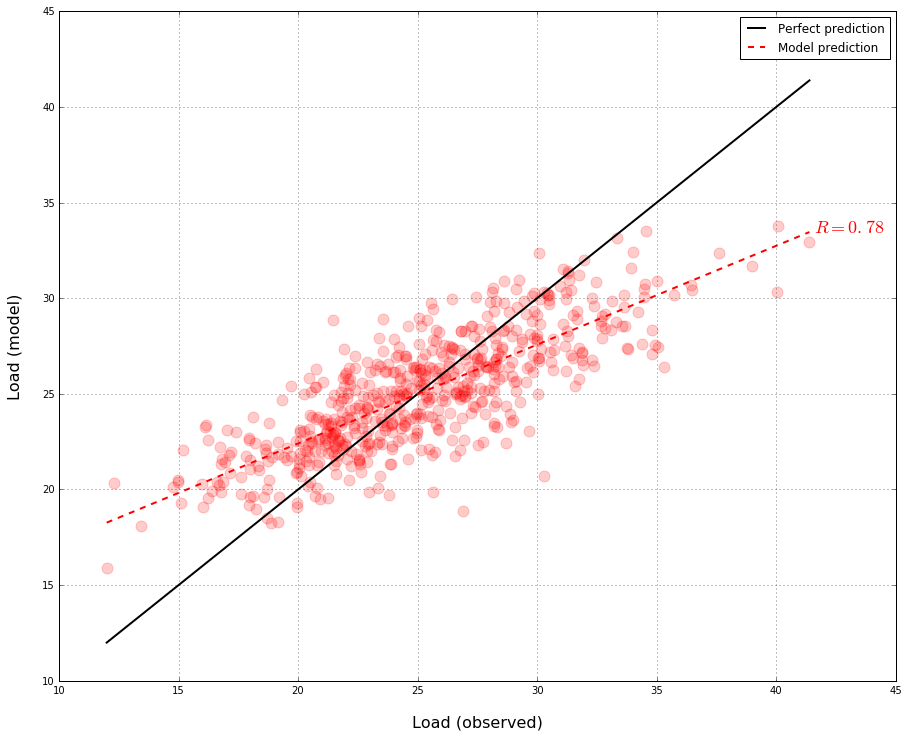

In [314]:
C = 1
model = Ridge(alpha=C, fit_intercept=True)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
mcm.fit(X_train, y_train)#, fit_params={'sample_weight': w})
y_pred = mcm.predict(X_test)
score = r2_score(y_test, y_pred)
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), 
                          scatter_color='red')


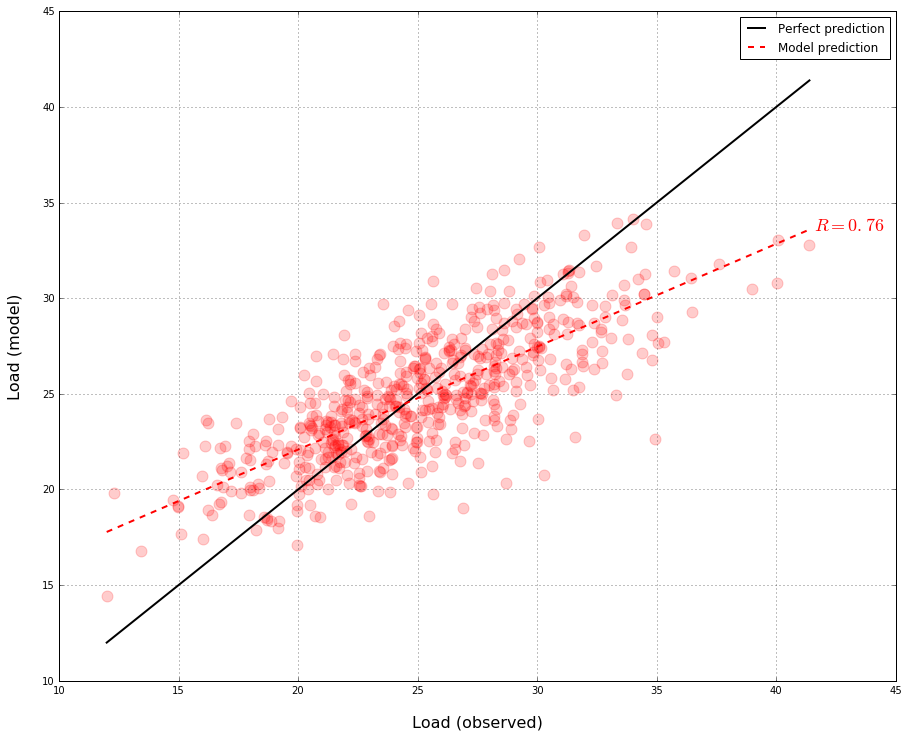

In [315]:
#UNWEIGHTED
C = 1
model =  Ridge(alpha=C, fit_intercept=False)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
sw = example_weights(y_train)**2
mcm.fit(X_train, y_train)#, fit_params={'sample_weight': sw})
y_pred = mcm.predict(X_test)
score = r2_score(y_test, y_pred)
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), 
                          scatter_color='red')

In [ ]:
#UNWEIGHTED
C = 1
model =  WeightedRidge(alpha=C, fit_intercept=True)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
sw = example_weights(y_train)**2
mcm.fit(X_train, y_train)#, fit_params={'sample_weight': sw})
y_pred = mcm.predict(X_test)
score = r2_score(y_test, y_pred)
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), 
                          scatter_color='red')

In [302]:
mcm.model.coef_.shape

(1207, 1)

In [291]:
ttt = X_train[0]
inte = np.ones((ttt.shape[0], 1))
xwint = np.hstack((inte, ttt))

In [292]:
print xwint.shape, inte.shape, ttt.shape

(1206, 4001) (1206, 1) (1206, 4000)


### Using channel weights

In [218]:
## with channel weights
gammas = [1,1,1,1,1,1]
kpt = create_kpt(6, gammas)
model = SVR(kernel='precomputed', C=5)
cw = np.array([.5, .5, 1, 1.5, 1, 3])
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt, channel_weights=None)
mcm.fit(X_train, y_train)
score = mcm.score(X_test, y_test)
print np.sqrt(score)

0.532914717428


In [206]:
#gammas = (Traj_gamma, HOG_gamma, HOF_gamma, MBHx_gamma, MBHy_gamma, 1)
gammas=(.5,1,1,1,.5,2) # THESE ARE FROM PREV TO CHECK IS WORKING
kpt = create_kpt(6, gammas)

#vary the exponent of individual accuracies as weights 
#to beat: 0.801581929458 with equal weights
exponent_range = [-3, -2, -1, -.5, -.1, 0, .1, .5, 1, 2, 3]
init_cw = np.array([.36, .46, .43, .44, .44, .54])
score_list = []
for exponent in exponent_range:
    cw = init_cw**exponent # the accuracies individually
    model = SVR(kernel='precomputed', C=5)
    mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt, channel_weights=cw)
    mcm.fit(X_train, y_train)
    score = mcm.score(X_test, y_test)
    score_list.append(np.sqrt(score))
    print exponent, score_list

-3 [0.80006523725247614]
-2 [0.80006523725247614, 0.80088341989320455]
-1 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624]
-0.5 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624, 0.80152013193373262]
-0.1 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624, 0.80152013193373262, 0.80157323575930661]
0 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624, 0.80152013193373262, 0.80157323575930661, 0.80158192945797591]
0.1 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624, 0.80152013193373262, 0.80157323575930661, 0.80158192945797591, 0.80158755599406561]
0.5 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624, 0.80152013193373262, 0.80157323575930661, 0.80158192945797591, 0.80158755599406561, 0.80159030334431469]
1 [0.80006523725247614, 0.80088341989320455, 0.80139224786187624, 0.80152013193373262, 0.80157323575930661, 0.80158192945797591, 0.80158755599406561, 0.80159030334431469, 0.80154405844099907]
2 [0.8000652372

In [204]:
print mcm.channel_weights

[ 1.2267032   1.16801504  1.18387625  1.1784454   1.1784454   1.13115273]


### With original summation rule...

In [221]:
gammas=(1, 1, 1, 1, 1, 1)
kpt = create_kpt(6, gammas)
C_range = [.001, .01, .1, 1, 10, 30, 100]
res_list=[]
for C in C_range:
    model = SVR(kernel='precomputed', C=C)
    mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt)
    score_list = multichannel_KFoldCV(mcm, X_train, y_train)
    res_list.append(np.mean(score_list))
    print C, score_list

0.001 [0.018853203463797596, 0.024793083773005598, 0.01718217199083949]
0.01 [0.15500045504326865, 0.15780503855044181, 0.16475475619732105]
0.1 [0.47482543268811839, 0.44348843120417392, 0.47100040455956405]
1 [0.61190852065715085, 0.56705897980076347, 0.58869071503420456]
10 [0.6139504293907212, 0.56866360428847218, 0.58990995330271523]
30 [0.6139504293907212, 0.56866360428847218, 0.58990995330271523]
100 [0.6139504293907212, 0.56866360428847218, 0.58990995330271523]


In [28]:
t0= time.time()
mcsvr = MultiChannelModel(num_channels=6, model_param_dict={'C':5}, kernel_param_tuple=kernel_param_tuple)
mcsvr.fit(X_train, y_train)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

training time: 13.6093559265


In [26]:
#predict
y_pred = mcsvr.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.641327668998 
Correlation of 0.800829363222


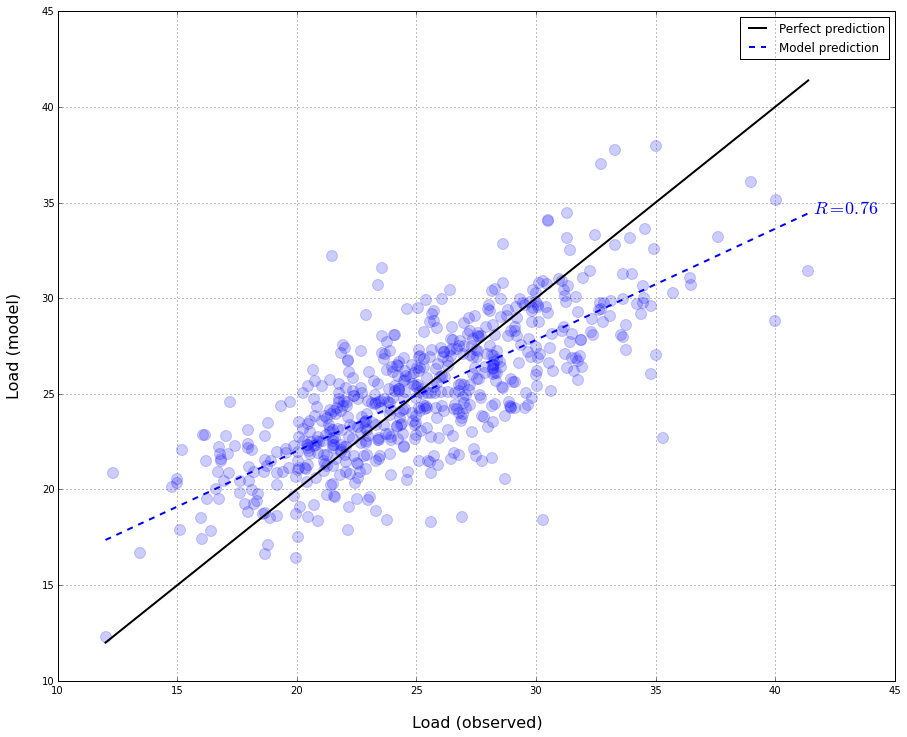

In [20]:
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), scatter_color='blue')#, title='Support Vector Regression (Improved Trajectories + c3d Features)')

In [76]:
video_name_list = map(lambda x: x[0], test_set.feature_dict['Video_Name'])
save_results(video_name_list=video_name_list, y_test=y_test, y_pred=y_pred)

##Multichannel SVR (improved trajectories + c3d) with weighted samples

In [27]:
#weight of training samples
scaler = MinMaxScaler(feature_range=(0,2))
sample_weight = (scaler.fit_transform(y_train))**20

t0 = time.time()
mcsvr_weighted = MultiChannelSVR2(num_channels=6, model_param_dict={}, kernel_param_tuple=kernel_param_tuple)
mcsvr_weighted.fit(X_train, y_train, sample_weight=sample_weight)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

/home/luke/anaconda2/envs/cvml/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/luke/anaconda2/envs/cvml/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


NameError: name 'MultiChannelSVR2' is not defined

In [181]:
#predict
y_pred_weighted = mcsvr_weighted.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.641326272675 
Correlation of 0.800828491423


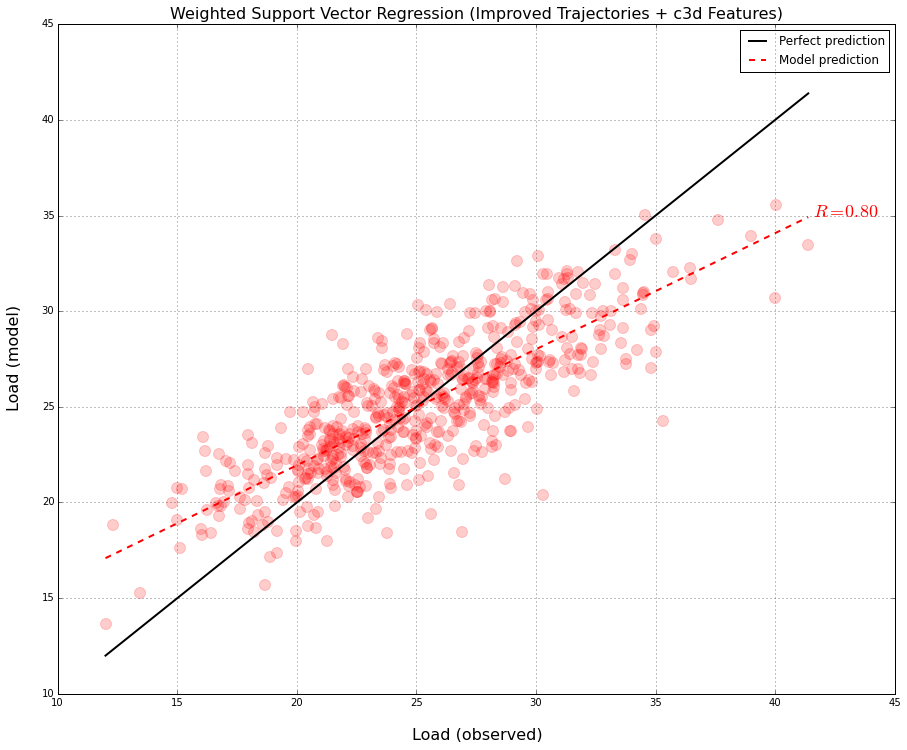

In [183]:
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), scatter_color='red', title='Weighted Support Vector Regression (Improved Trajectories + c3d Features)')

##Multichannel SVR with improved trajectories only

In [184]:
feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy']
X_train, y_train = prep_multichannel_data(train_data, return_labels=True, feature_list=feature_list)
X_test, y_test = prep_multichannel_data(test_data, return_labels=True, feature_list=feature_list)

In [185]:
#define the kernel parameters for each channel
chi2_gammas=(.5,1,1,1,.5)
kernel_param_list = [ {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}} for gamma in chi2_gammas]
kernel_param_tuple = tuple(kernel_param_list)

In [186]:
t0 = time.time()
mcsvr = MultiChannelSVR2(num_channels=5, model_param_dict={'C':5}, kernel_param_tuple=kernel_param_tuple)
mcsvr.fit(X_train, y_train, sample_weight=None)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

training time: 122.472000122


In [187]:
#predict
y_pred = mcsvr.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.60408159318 
Correlation of 0.77722686082


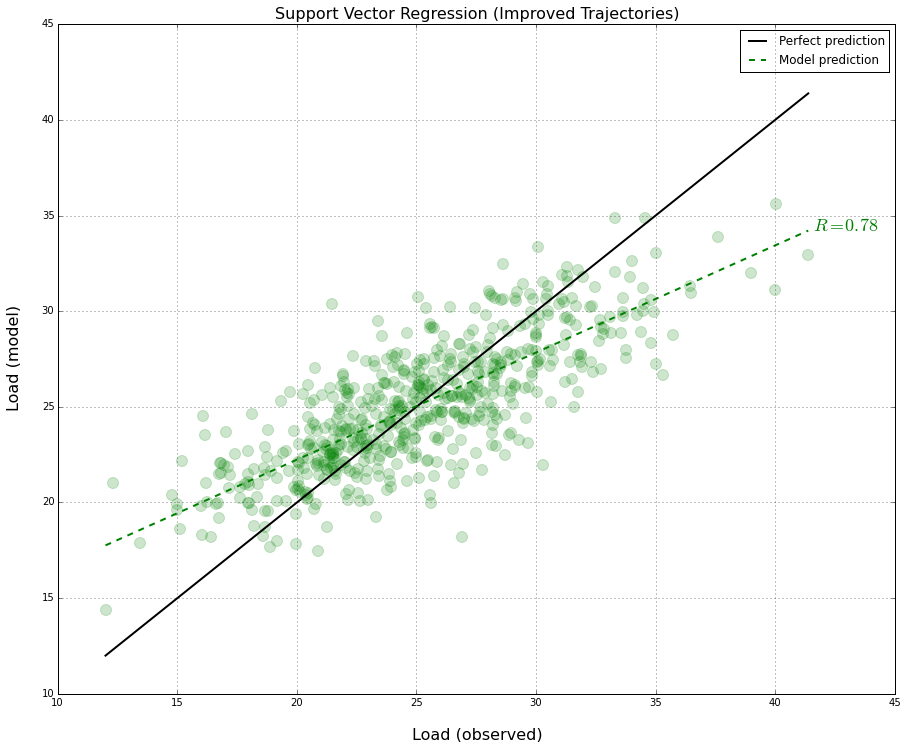

In [189]:
fig, ax = plot_regression(y_test, y_pred, score=np.sqrt(score), scatter_color='green', title='Support Vector Regression (Improved Trajectories)')